## **Uploading Image Dataset:**


In [3]:
from google.colab import files
import zipfile
import os

# Upload the zip file
uploaded = files.upload()

# Extract the uploaded zip file
for file_name in uploaded.keys():
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall()


Saving casting_data.zip to casting_data.zip


#**MODEL 1:**

### **Setting up Data generators:**

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_data_dir = 'casting_data/train'
test_data_dir = 'casting_data/test'

# Image data generator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Image data generator for testing (no data augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),  #VGG16 and other models often use 224x224 images
    batch_size=32,
    class_mode='binary',
    classes=['def_front', 'ok_front']
)

# Flow testing images in batches of 32 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=['def_front', 'ok_front']
)


Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


##**Building the model:**

In [22]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

def build_model(input_shape=(224, 224, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)  # Increase neurons in the dense layer
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build the model
model = build_model()


##**Training the Model:**

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callback to reduce learning rate when the validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# Early stopping to terminate training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model for more epochs and adjust the learning rate
history = model.fit(
    train_generator,
    epochs=20,  # Train for more epochs
    validation_data=test_generator,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/20
208/208 [==============================] - 97s 466ms/step - loss: 0.2775 - accuracy: 0.8836 - val_loss: 0.1328 - val_accuracy: 0.9832 - lr: 0.0010
Epoch 2/20
208/208 [==============================] - 94s 454ms/step - loss: 0.2097 - accuracy: 0.9177 - val_loss: 0.2505 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 3/20
208/208 [==============================] - 95s 454ms/step - loss: 0.1732 - accuracy: 0.9367 - val_loss: 0.1024 - val_accuracy: 0.9636 - lr: 0.0010
Epoch 4/20
208/208 [==============================] - 94s 453ms/step - loss: 0.1637 - accuracy: 0.9424 - val_loss: 0.0914 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/20
208/208 [==============================] - 93s 449ms/step - loss: 0.1905 - accuracy: 0.9224 - val_loss: 0.0802 - val_accuracy: 0.9720 - lr: 0.0010
Epoch 6/20
208/208 [==============================] - 94s 450ms/step - loss: 0.1671 - accuracy: 0.9343 - val_loss: 0.1207 - val_accuracy: 0.9566 - lr: 0.0010
Epoch 7/20
208/208 [==============================] 

###**Evaluating the Model:**

In [15]:
# Generate predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")


23/23 [==============================] - 3s 124ms/step


In [16]:
from sklearn.metrics import confusion_matrix

# Get true labels
true_labels = test_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)
print(conf_matrix)


[[295 158]
 [159 103]]


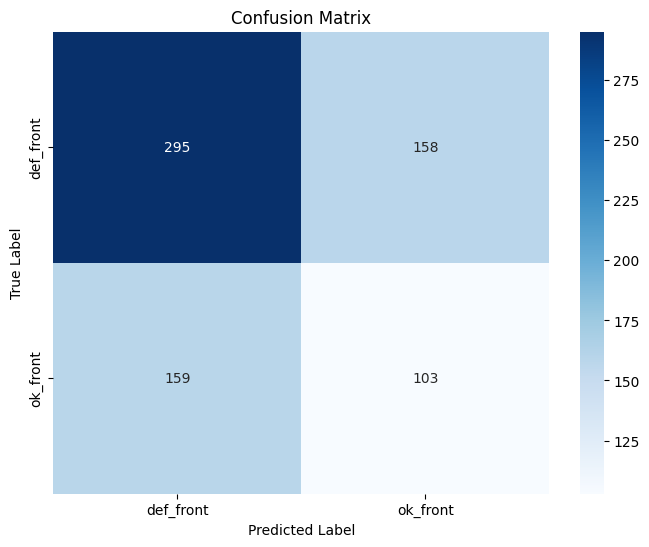

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['def_front', 'ok_front'], yticklabels=['def_front', 'ok_front'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_classes)

# Calculate precision
precision = precision_score(true_labels, predicted_classes)

# Calculate recall (sensitivity)
recall = recall_score(true_labels, predicted_classes)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



Accuracy: 0.5342657342657343
Precision: 0.36398467432950193
Recall: 0.36259541984732824
F1 Score: 0.36328871892925435
